In [1]:
import sys
sys.path.append('/vol/tensusers5/nhollain/s_clip_scripts')

from s_clip_scripts.data_loader import get_data, get_custom_data, TokenizedDataset, create_datainfo
from s_clip_scripts.tools import read_json
from collections import Counter
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('./data')

['sydney_captions',
 'scicap_data.zip',
 'polyvore',
 'scicap',
 'fashion200k',
 'UCM_captions.zip',
 'RSICD.zip',
 'polyvore-images.tar.gz',
 'RSICD',
 'UCM',
 'UCMerced_LandUse',
 'WHU-RS19',
 'RSSCN7',
 'AID',
 'NWPU-RESISC45',
 'kaggle_simpsons_characters.zip',
 'kaggle_simpsons_characters',
 'polyvore_outfits.zip',
 'polyvore_outfits',
 'fashiongen',
 'test',
 '.ipynb_checkpoints']

['RSICD_images', 'dataset_rsicd.json', 'txtclasses_rsicd.rar', 'txtclasses_rsicd']


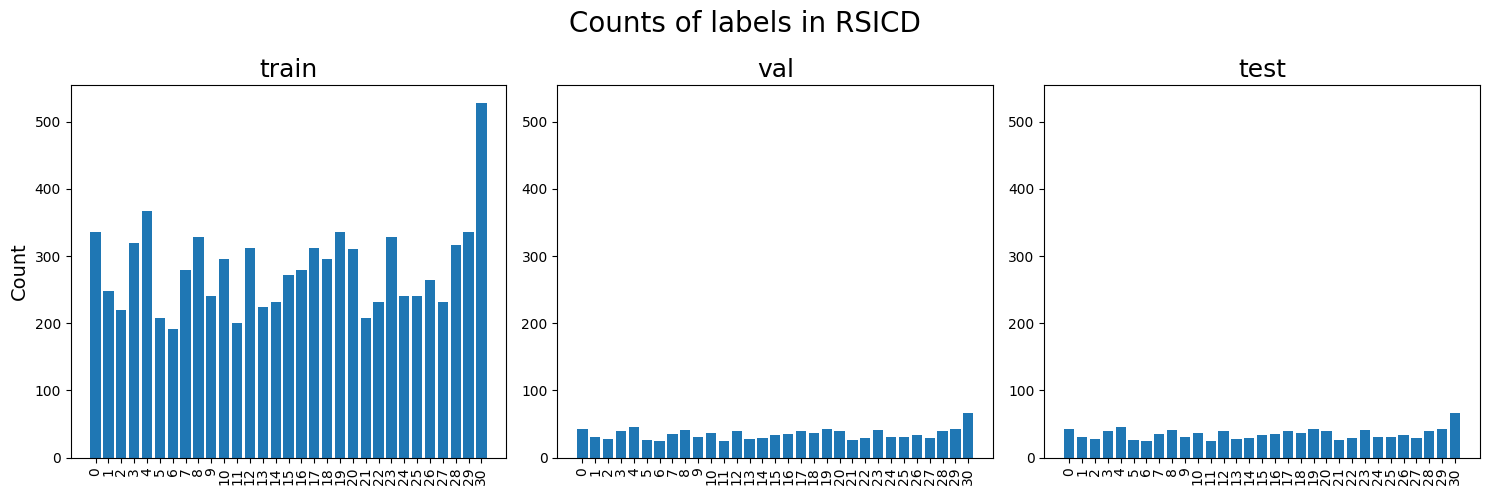

In [3]:
print(os.listdir('./data/RSICD'))

def load_captions(path: str, split: str):
        captions = read_json(path)["images"]
        return [c['filename'] for c in captions if c["split"] == split]

def plot_counts_rsicd(split):
    data = load_captions('./data/RSICD/dataset_rsicd.json', split)
    
    classes = []
    path2class = {}
    
    class_dir = './data/RSICD/txtclasses_rsicd'
    for idx, fn in enumerate(sorted(os.listdir(class_dir))):
        classes.append(fn.split(".txt")[0])
        with open(os.path.join(class_dir, fn)) as f:
            for line in f.readlines():
                path2class[line.strip()] = idx

    path2class = {key:path2class[key] for key in data}
    path2class_lst = list(path2class.values())
    paths = list(path2class.keys())
    labels, counts = np.unique(path2class_lst, return_counts=True)
    return labels, counts, paths
    # plt.title('RSICD label counts ({})'.format(split))
    # plt.ylabel('Count')
    # plt.bar(labels, counts, align='center')
    # plt.xticks(labels, rotation = 90)
    # plt.show()
    # return paths

train_labels, train_counts, train_paths = plot_counts_rsicd('train')
val_labels, val_counts, val_paths = plot_counts_rsicd('val')
test_labels, test_counts, test_paths = plot_counts_rsicd('test')

len(set(test_paths).intersection(set(val_paths)))

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
plt.xticks(rotation = 90)
ax[0].set_ylabel('Count', fontsize = 14)
ax[0].bar(train_labels, train_counts, align = 'center')
ax[1].bar(val_labels, val_counts, align = 'center')
ax[2].bar(test_labels, test_counts, align = 'center')

all_counts = np.stack([train_counts, val_counts, test_counts])
max_count = np.max(all_counts)
splits = ['train', 'val', 'test']
for i, a in enumerate(ax):
    a.set_xticks(train_labels)
    a.set_xticklabels(train_labels, rotation = 90)
    a.set_title(splits[i], fontsize = 18)
    a.set_ylim(0, max_count*1.05)
plt.suptitle('Counts of labels in RSICD', fontsize = 20)    
plt.tight_layout()

In [47]:
split_classes = []
for d in data:
    split_classes.append(path2class[d['filename']])
Counter(split_classes)

Counter({30: 528,
         4: 367,
         0: 336,
         19: 336,
         29: 336,
         8: 328,
         23: 328,
         3: 320,
         28: 316,
         12: 312,
         17: 312,
         20: 311,
         10: 296,
         18: 296,
         7: 280,
         16: 280,
         15: 272,
         26: 264,
         1: 248,
         9: 240,
         24: 240,
         25: 240,
         14: 232,
         22: 232,
         27: 232,
         13: 224,
         2: 220,
         5: 208,
         21: 208,
         11: 200,
         6: 192})

In [1]:
from itertools import chain
from s_clip_scripts.main import main
from s_clip_scripts.params import parse_args

fashion = False

if fashion:
    str_args = '''--train-data Fashion-ALL
            --label-ratio 0.1
            --val-data Fashion-ALL
            --keyword-path keywords/fashion/class-name.txt
            --epochs 10
            --method base  
    '''
else:
    str_args = ''' --train-data RS-ALL
            --label-ratio 0.1
            --val-data RS-ALL
            --imagenet-val RSICD-CLS \
            --keyword-path keywords/RS/class-name.txt
            --epochs 25
            --zeroshot-frequency 5  
            --method ours
            --use_vit
    '''
str_args = str_args.split('\n')
str_args = [s.strip() for s in str_args]
str_args = [s.split(' ') for s in str_args]
str_args = list(chain(*str_args))
str_args = [s for s in str_args if len(s) > 0]
args = parse_args(str_args)

In [13]:
from open_clip import create_model_and_transforms, get_tokenizer, create_loss
from s_clip_scripts.model import create_custom_model
args.device = 'cuda:0' 
model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model, args.pretrained, precision=args.precision, device=args.device, output_dict=True,
        aug_cfg = args.aug_cfg, )
model = create_custom_model(args, model)
data = get_data(args, (preprocess_train, preprocess_val), tokenizer=get_tokenizer(args.model))

RS-ALL
Split: val
Data size: 1094
Data size: 210
Data size: 58
RSICD-CLS
Split: val
['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct', 'playfields']
RS-ALL
Split: train
Data size: 8734
Data size: 1680
Data size: 497
Dataset length: 10911
Labeled size: 1091
D1 indices: tensor([10892,  6980,  2351,  ...,  7490, 10454,  5047])
D2 indices: tensor([10476,   757,  2238,  ...,  3598,  8635,  3590])


In [19]:
for img, target in iter(data['val'].dataloader):
    print(target)

tensor([[49406,   320,  2866,  ...,     0,     0,     0],
        [49406,  1346,  1579,  ...,     0,     0,     0],
        [49406,   320,  5363,  ...,     0,     0,     0],
        ...,
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0]])
tensor([[49406,   320,  2754,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        [49406,   585,   533,  ...,     0,     0,     0],
        ...,
        [49406,  1573,   533,  ...,     0,     0,     0],
        [49406,   320,  2754,  ...,     0,     0,     0],
        [49406,  7882,   572,  ...,     0,     0,     0]])
tensor([[49406,   320,  3638,  ...,     0,     0,     0],
        [49406,  1573,   533,  ...,     0,     0,     0],
        [49406,  1579,  7882,  ...,     0,     0,     0],
        ...,
        [49406,   550, 15039,  ...,     0,     0,     0],
        [49406,   320,  3638,  

In [3]:
# PROBLEMS WITH POLYVORE DATA: the data structure seems to be different from what the S-CLIP paper uses.
# I want to probably get the dict['items'] values for each folder and then take the images from there.
working_datasets = ['RSICD', 'UCM', 'Sydney', 'Fashion200k', 'SciCap', 'RSICD-CLS', 'UCM-CLS', 'Fashion200k-CLS', 'WHU-RS19', 'RSSCN7', 
                    'AID', 'RESISC45', 'Simpsons-Images', 'Polyvore', 'Polyvore-CLS', 'FashionGen', 'FashionGen-CLS']
# get_custom_data(args, data, preprocess_fn, is_train, cls, subclass, **data_kwargs):
for dataset in working_datasets:
    print(dataset)
    cls = 'CLS' in dataset
    # CLS version of most datasets just uses the non-CLS dataloader, but adds cls = True as argument
    if dataset != 'UCM-CLS': # Exception: UCM-CLS is a different dataloader altogether than UCM!
        dataset = dataset.replace('-CLS', '')
    get_custom_data(None, data = dataset, preprocess_fn = None, is_train = True, cls = cls, subclass = False)

RSICD
UCM
Sydney
Fashion200k
SciCap
RSICD-CLS
UCM-CLS
Fashion200k-CLS
WHU-RS19
RSSCN7
AID
RESISC45


In [1]:
get_custom_data(None, data = 'Simpsons-Images', preprocess_fn = None, is_train = True, cls = True, subclass = False)

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: ./data/kaggle_simpsons_characters/simpsons_dataset

In [6]:
%%time
from tools import read_json
path = './data/polyvore_outfits/disjoint'
split_info = read_json(os.path.join(path, 'train.json'))
path = './data/polyvore_outfits/polyvore_item_metadata.json'
metadata = read_json(path)

CPU times: user 1.32 s, sys: 192 ms, total: 1.51 s
Wall time: 1.51 s


In [11]:
%%time
split_item_ids = []
for grouping in split_info:
    items = grouping['items']
    item_ids = [item['item_id'] for item in items] # Get image IDs
    split_item_ids += item_ids
split_item_ids   

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.9 ms


['132621870',
 '153967122',
 '171169800',
 '162799044',
 '172538912',
 '172312529',
 '162715806',
 '171888747',
 '173096665',
 '170904692',
 '172482221',
 '180028994',
 '182218570',
 '180850592',
 '179806210',
 '181657245',
 '165695205',
 '198643069',
 '206048471',
 '204007990',
 '200709959',
 '195973920',
 '200139640',
 '156489567',
 '148693800',
 '200313980',
 '204650506',
 '208870650',
 '207173723',
 '207871410',
 '208870252',
 '199376553',
 '203551771',
 '203552462',
 '175711802',
 '210942072',
 '212839321',
 '213855157',
 '207459533',
 '192511179',
 '187317072',
 '180362994',
 '191221027',
 '173097736',
 '172685140',
 '164453126',
 '169982065',
 '169809127',
 '213007746',
 '212992927',
 '214327110',
 '207668984',
 '181900351',
 '202212715',
 '209966118',
 '70625358',
 '208664157',
 '193455194',
 '211421142',
 '161180948',
 '158857944',
 '88909845',
 '119901618',
 '107732394',
 '166542899',
 '151124575',
 '133932837',
 '161950492',
 '210326667',
 '209505560',
 '50235496',
 '2006396

In [24]:
%%time
data = []
cls = False
item_keys = set(metadata.keys())
split_item_ids = set(split_item_ids)
intersect = item_keys.intersection(split_item_ids)
for item_key in intersect:
    # if item_key not in split_item_ids: # Skip items not in the current split
    #     continue
    item = metadata[item_key]
    item_path = item_key + '.jpg'
    if cls: # For classification, we use the (sub)category as the class label
        data.append({"image_path": item_path, "class_name": item["semantic_category"]}) 
    else: # For captions, we use the fashion item's title (=name) and description as its caption
        data.append({"image_path": item_path, "sentences": item["title"] + "." + item["description"]})

CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 192 ms


In [23]:
%%time
item_keys = list(metadata.keys())
len(set(item_keys)), len(set(split_item_ids)), len(item_keys), len(split_item_ids)
intersect = set(item_keys).intersection(set(split_item_ids))
len(intersect)

CPU times: user 85.7 ms, sys: 0 ns, total: 85.7 ms
Wall time: 85.3 ms


71967

In [ ]:
# 200 ms